In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow_probability as tfp
from scipy.integrate import odeint

from rnn_library import rnn_functions as rnn # importing local package as rnn
                                             # for details see rnn_functions.py file in rnn_libary folder 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

In [3]:
def NL_DifEq(x,t):
    """
    NL_DifEq specifies the set of ODE's that need to be solved.
    Applied within odeint. For more details look into scipy.integrate.odeint

    Requierements:
    
    x         -   initial value satisfied by Initial_Condition.
    t         -   timeline satsfied by 
    
    Output:
    
    dxdt     -   the change in the dynamic network variable x
    """
    
    dxdt = - x + J_Matrix @ np.tanh(x) 
    
    return dxdt

In [26]:
'''
In this cell we ask the user to specify 
the network parameters:
g, K, N_values, s_values
'''

g = 2.0                     # stores the value of the gain parameter in the network; datatype float

N_values = [850, 150]       # stores number of clusters for each population
s_values = [1.0, 3.5]       # stores values of self-coupling each cluster population

K = len(N_values)           # stores the total number of distinct clusters; datatype positive int     
N = int(np.sum(N_values))     # stores total number of clusters in the network

In [27]:
# Specifying the timeline for solving the coupled ODEs

t_end = 2000.0                        # end of time  
dt = 0.1                              # timestep
timeline = np.arange(0, t_end, dt)    # stores time values t0 = 0, t1= 0.1, ....

# Specifying the timeline for the autocorrelation funcion (ACF)

steps_ignore = 500                             # minimum value 1 (see how the ACF is computed)
Tau_Steps = int((t_end*(1/dt)-steps_ignore))   # total number of steps for the ACF timeline
tau_timeline = np.arange(0,Tau_Steps,1.0)*dt   # stores time values t0 = 0, t1= 0.1, ....

# Specifying the network connectivity matrix J

# J is extracted from a normal distribution with mean 0 and variance g/sqrt(N)

mean  = 0.0                                          # mean of the distribution
variance  = g/np.sqrt(N)                             # variance of teh distribution
J_Matrix = variance * np.random.randn(N**2) + mean   # returns an array of size N*N
J_Matrix = J_Matrix.reshape(N,N)                     # reshaping the array into a NxN matrix

# Specifying the diagonal elements of the J matrix

diagonal = np.ones(N)
temp_pos_var = 0 # not an elegant solution, but it works
for idx in range(K):
    range_start = int(temp_pos_var)
    range_end = int(temp_pos_var+N_values[idx])
    
    diagonal[range_start:range_end] = diagonal[range_start:range_end]* s_values[idx]
    
    temp_pos_var = N_values[idx]
    
for cluster in range(N):
    J_Matrix[cluster][cluster] = diagonal[cluster]

# Specifying the initial conditions x(t = 0)
Initial_Condition = np.random.uniform(-2,2, N) # N size array from uniform distr. ranging from -2 to 2

In [30]:
# Solving the system of coupled ODE with the specified parameters

x = odeint(NL_DifEq, Initial_Condition, timeline).T

# Solving for the ACF < phi[x(t)] phi[x(t+tau)] > ; phi[x] = tanh[x]

C_phi   = tfp.stats.auto_correlation(np.tanh(x[:,steps_ignore:]), axis =-1, max_lags = Tau_Steps, center = False, normalize = True)

# Averaging the ACF per cluster population
C_phi_avg = []

# stores the average HWHM per population  
timescales = []

temp_pos_var = 0 # not an elegant solution, but it works
for idx in range(K):
    range_start = int(temp_pos_var)
    range_end = int(temp_pos_var+N_values[idx])
    
    C_phi_avg.append(np.mean( C_phi[range_start:range_end] , axis = 0))
    
    temp_pos_var = N_values[idx]

    timescales.append(rnn.FWHM_funct(tau_timeline , C_phi_avg[idx]))

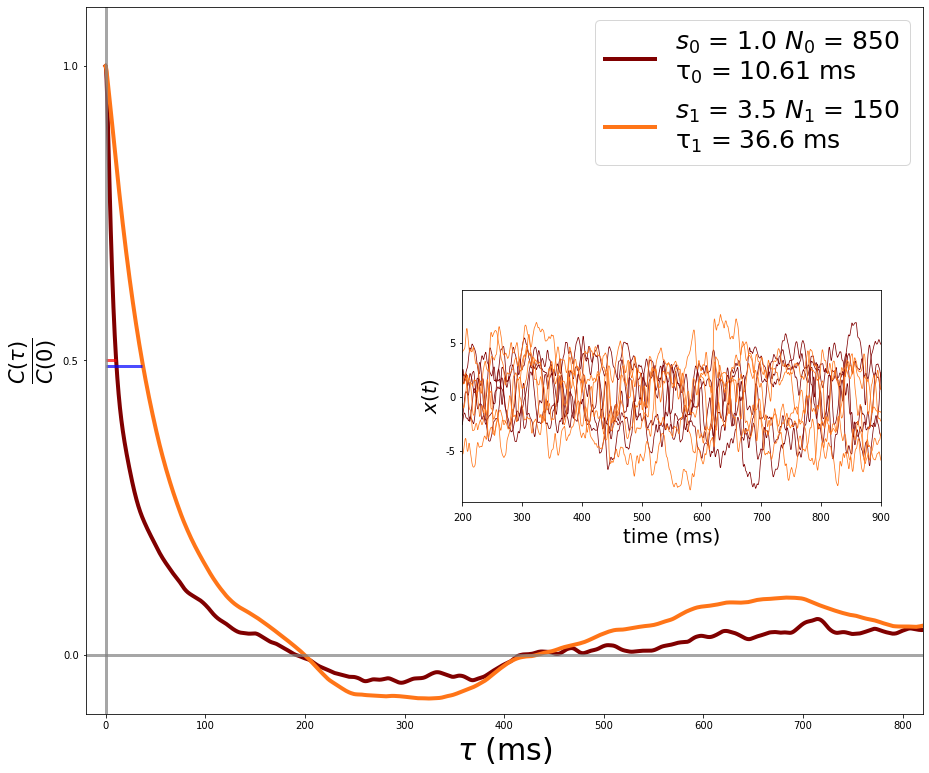

In [40]:
color_list = ['#800000', '#FF7518', '#FFDF00', '#8DB600', '#89CFF0', '#FFC0CB']
color_list_1 = ['red','blue', 'green', 'purple', 'gold']

fig, ax1 = plt.subplots(figsize = (15, 13))

##############################################################
####### ACF

for idx in range(K):
    ax1.plot(tau_timeline, C_phi_avg[idx], linewidth = 4, color = color_list[idx], 
             label = f'$s_{idx}$ = {s_values[idx]} $N_{idx}$ = {N_values[idx]}\n\u03C4$_{idx}$ = {np.round(timescales[idx],2)} ms')
    ax1.hlines(0.50-0.01*idx, 0, timescales[idx], color = color_list_1[idx], linewidth = 3, alpha  = 0.7)
    
ax1.hlines(0, -100, Tau_Steps*dt, color = 'gray', linewidth = 3, alpha  = 0.7)
ax1.vlines(0, -0.5, 1.5, color = 'gray', linewidth = 3, alpha  = 0.7)

ax1.legend(loc=0, fontsize = 25)

ax1.set_xlabel(r'$\tau$ (ms)', fontsize = 30)
ax1.set_ylabel(r'$\frac{C(\tau)}{C(0)}$', fontsize = 30)

##############################################################
####### Behavior

num_samples = 5

ranges = []
for i in range(K,-1,-1):
    ranges.append(N - np.sum( N_values[ : i] ) )

neuron_idx = []
for i in range(K):
    neuron_idx.append(np.random.randint(ranges[i], ranges[i+1], num_samples))

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.45,0.3,0.5,0.3]) #left bottom width height
ax2.set_axes_locator(ip)


# The data: only display for low temperature in the inset figure.
for i in range(K):
    ax2.plot(timeline, x[neuron_idx[i][0]], color = color_list[i], linewidth = 0.75)
    for j in range(1, num_samples): 
        ax2.plot(timeline, x[neuron_idx[i][j]], color = color_list[i] , linewidth = 0.75)

ax2.set_xlabel(r'time (ms)', fontsize = 20)
ax2.set_ylabel(r'$x(t)$', fontsize = 20)

# Some ad hoc tweaks.
ax1.set_xlim(-20,820)
ax1.set_ylim(-0.1,1.1)

ax1.set_yticks([0, 0.5, 1])
ax1.set_yticklabels(ax1.get_yticks(), backgroundcolor='w')

# behavior time range
timeline_start = 200
timeline_end   = 900 
ax2.set_xlim(timeline_start, timeline_end)

ax2.set_xticks(np.arange( timeline_start , timeline_end+1 ,100))
ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor='w')
ax2.set_yticks([-5, 0, 5])
ax2.set_yticklabels(ax2.get_yticks(), backgroundcolor='w')
ax2.tick_params(axis='x', which='major', pad=8)

plt.show()